### ANOVA
- 세 집단 이상의 평균의 차이가 유의미한가를 확인하기 위해 사용하는 분석 방법
- 정규성, 등분산성, 독립성 조건이 전제 되어야 함

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('../data/sales.csv', dtype={'YMD':'object'})
wt = pd.read_csv('../data/weather.csv')

In [2]:
data.head()

,YMD,AMT,CNT
0,20190514,0,1
1,20190519,18000,1
2,20190521,50000,4
3,20190522,125000,7
4,20190523,222500,13


In [3]:
wt.head()

,stnId,tm,avgTa,minTa,maxTa,sumRn,maxWs,avgWs,ddMes
0,108,2018-06-01,23.8,17.5,30.2,0.0,4.3,1.9,0.0
1,108,2018-06-02,23.4,17.6,30.1,0.0,4.5,2.0,0.0
2,108,2018-06-03,24.0,16.9,30.8,0.0,4.2,1.6,0.0
3,108,2018-06-04,22.6,18.9,27.5,0.0,4.4,1.9,0.0
4,108,2018-06-05,23.7,17.7,29.2,0.0,4.0,1.7,0.0


In [4]:
wt['tm'] = wt['tm'].apply(lambda x: x.replace('-',''))

In [5]:
wt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   stnId   702 non-null    int64  
 1   tm      702 non-null    object 
 2   avgTa   702 non-null    float64
 3   minTa   702 non-null    float64
 4   maxTa   702 non-null    float64
 5   sumRn   702 non-null    float64
 6   maxWs   702 non-null    float64
 7   avgWs   702 non-null    float64
 8   ddMes   702 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 49.5+ KB


In [6]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   YMD     328 non-null    object
 1   AMT     328 non-null    int64 
 2   CNT     328 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.8+ KB


In [10]:
DF = data.merge(wt, how='left', right_on='tm', left_on='YMD')

data = DF.iloc[:,[0,2,7,8]]
data[:6]

,YMD,CNT,maxTa,sumRn
0,20190514,1,26.9,0.0
1,20190519,1,21.6,22.0
2,20190521,4,23.8,0.0
3,20190522,7,26.5,0.0
4,20190523,13,29.2,0.0
5,20190524,12,33.4,0.0


In [11]:
data.describe()

,CNT,maxTa,sumRn
count,328.000000,328.000000,328.000000
mean,40.823171,18.597866,2.699390
std,18.908580,10.163039,8.825886
min,1.000000,-4.900000,0.000000
25%,27.000000,9.375000,0.000000
50%,38.000000,19.350000,0.000000
75%,55.000000,27.800000,0.200000
max,97.000000,36.800000,63.200000


- 일별 최고온도 -> 구간 설정을 통해 연속형 변수를 명목형 변수로 바꿈

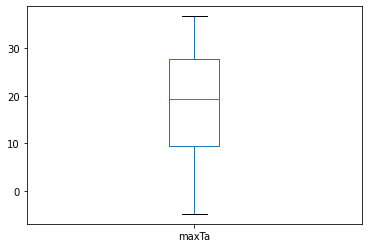

In [15]:
data.boxplot(column='maxTa', grid=False)
plt.show()

In [23]:
print(data.maxTa.max())
print(data.maxTa.min())
print(data.maxTa.median())
print(data.maxTa.mean())
print(data.maxTa.quantile(0.33))
print(data.maxTa.quantile(0.66))
data['Ta_gubun'] = pd.cut(data.maxTa, bins=[-5,13,26,37], labels=[0,1,2])

36.8
-4.9
19.35
18.597865853658536
12.8
26.082000000000004


In [33]:
data[data.Ta_gubun.isna()]

,YMD,CNT,maxTa,sumRn,Ta_gubun


- 본격적인 검정에 앞서 간단히 상관분석을 진행

In [35]:
data.corr()

,CNT,maxTa,sumRn
CNT,1.000000,-0.709555,-0.095322
maxTa,-0.709555,1.000000,0.119268
sumRn,-0.095322,0.119268,1.000000


- 세 그룹을 데이터를 나누어 준 뒤, 등분산 검정과 정규성 검정을 함께 수행

In [42]:
xs = [np.array(data[data.Ta_gubun == i]['CNT']) for i in range(3)]

[array([66, 64, 64, 50, 72, 74, 68, 62, 63, 72, 85, 65, 63, 78, 74, 67, 57,
        75, 63, 75, 72, 65, 64, 75, 89, 62, 91, 76, 64, 73, 73, 68, 97, 89,
        76, 76, 74, 79, 69, 95, 67, 81, 74, 51, 47, 42, 53, 48, 49, 24, 57,
        60, 63, 55, 73, 45, 51, 60, 48, 51, 55, 39, 65, 59, 54, 31, 61, 46,
        62, 51, 46, 56, 67, 59, 59, 54, 66, 58, 54, 56, 58, 25, 63, 51, 56,
        58, 40, 46, 49, 65, 49, 58, 58, 48, 36, 44, 49, 47, 49, 55, 39, 37,
        42, 32, 43, 43, 37, 30, 39, 42, 40, 60], dtype=int64),
 array([ 1,  4, 13, 11, 14, 13, 20, 20,  8, 18, 22, 12, 23, 21, 38, 36, 20,
        29, 36, 46, 38, 27, 42, 32, 32, 38, 32, 36, 37, 46, 29, 39, 28, 36,
        22, 24, 45, 29, 31, 23, 23, 24, 26, 17, 24, 14, 30, 18, 17, 28, 20,
        20, 72, 53, 50, 65, 55, 57, 73, 68, 78, 58, 57, 45, 53, 34, 44, 33,
        39, 27, 34, 38, 40, 44, 37, 37, 29, 31, 41, 32, 42, 43, 41, 35, 34,
        51, 41, 41, 55, 42, 42, 30, 46, 43, 39, 42, 45, 51, 41, 51, 34, 55,
        45, 45], dtype=in

[]

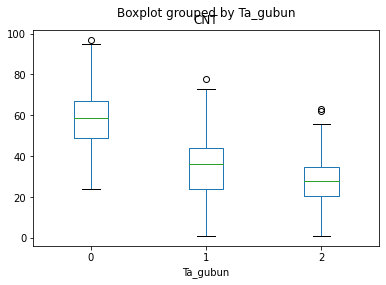

In [50]:
data.boxplot(column='CNT',by='Ta_gubun', grid=False)
plt.plot()

In [48]:
data.groupby('Ta_gubun').count()

,YMD,CNT,maxTa,sumRn
Ta_gubun,,,,
0,112,112,112,112
1,104,104,104,104
2,112,112,112,112


In [54]:
from scipy import stats
# 등분산 검정
print(stats.bartlett(xs[0],xs[1],xs[2]),stats.fligner(xs[0],xs[1],xs[2]), stats.levene(xs[0],xs[1],xs[2]), sep='\n')

BartlettResult(statistic=13.729198000455197, pvalue=0.0010441010529133724)
FlignerResult(statistic=12.015409721143207, pvalue=0.0024597271235625856)
LeveneResult(statistic=6.004297664820322, pvalue=0.0027503457908888405)


In [59]:
# 정규성 검정
print(stats.ks_2samp(xs[0],xs[1]), stats.ks_2samp(xs[1],xs[2]), stats.ks_2samp(xs[2],xs[1]), sep='\n')

KstestResult(statistic=0.6311813186813187, pvalue=1.1102230246251565e-16)
KstestResult(statistic=0.30494505494505497, pvalue=6.071012343955573e-05)
KstestResult(statistic=0.30494505494505497, pvalue=6.071012343955573e-05)


- 정규성 검정, 등분산 검정 둘다 만족하지 않음
## ANOVA 분석 진행
- 추후 정규성, 등분산성 조건 각각 충족하지 못하는 경우를 고려하여 추가분석도 진행

In [68]:
ssp = data.loc[:,['CNT','Ta_gubun']]
sp = np.array(ssp)

group1 = sp[sp[:,1] == 0, 0]
group2 = sp[sp[:,1] == 1, 0]
group3 = sp[sp[:,1] == 2, 0]

array([66, 64, 64, 50, 72, 74, 68, 62, 63, 72, 85, 65, 63, 78, 74, 67, 57,
       75, 63, 75, 72, 65, 64, 75, 89, 62, 91, 76, 64, 73, 73, 68, 97, 89,
       76, 76, 74, 79, 69, 95, 67, 81, 74, 51, 47, 42, 53, 48, 49, 24, 57,
       60, 63, 55, 73, 45, 51, 60, 48, 51, 55, 39, 65, 59, 54, 31, 61, 46,
       62, 51, 46, 56, 67, 59, 59, 54, 66, 58, 54, 56, 58, 25, 63, 51, 56,
       58, 40, 46, 49, 65, 49, 58, 58, 48, 36, 44, 49, 47, 49, 55, 39, 37,
       42, 32, 43, 43, 37, 30, 39, 42, 40, 60], dtype=object)